In [1]:
import pandas as pd
import numpy as np
import math 
import os 
from datetime import datetime, timedelta
import pymap3d # python3 -m pip install pymap3d
import random
import pickle
from scipy.special import lambertw
from scipy import stats
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output, save
from bokeh.layouts import gridplot, row, column
from bokeh.models import Range1d
output_notebook() 
# output_notebook() 

save_data_bool = False # Save data or not

Loading BokehJS ...

## Import data

In [2]:
dataset="cabspotting" # OPTIONS ARE: cabspotting privamov
user="oilrag" # Examples: abboip oilrag 51 90 14

In [3]:
local_url="datasets/"+dataset+"-tree/"+user+".csv"
sol_file='solutions/'+dataset+'/'+user
exists = os.path.isfile(local_url)
if exists:
    data = pd.read_csv(local_url,names=["latitude","longitude","timestamp"])
    print("uploaded from local file")
else:
    print("data not found")
#[x,y,time]=import_trace(dataset,user)


if not os.path.exists(sol_file):
    os.makedirs(sol_file)

    

uploaded from local file


In [4]:
data['time']=[datetime.utcfromtimestamp(tstamp/1000) for tstamp in data['timestamp']]
data['elapsedtime']=(data['timestamp']-data['timestamp'][0])/1000
whole_duration = data['elapsedtime'][len(data['timestamp'])-1]/60
print('Whole duration: '+str(math.floor(whole_duration))+' min')

Whole duration: 1126 min


In [5]:
data=data.set_index('time').sort_index().copy()
ell_grs80 = pymap3d.Ellipsoid('grs80') 
data['altitude']=np.zeros(len(data.index))
lat0, lon0, h0 = data['latitude'][0],data['longitude'][0],data['altitude'][0]
data['x'], data['y'], data['u_enu'] = pymap3d.geodetic2enu(data['latitude'], data['longitude'], data['altitude'], lat0, lon0, h0, ell=ell_grs80)
data.head()

,latitude,longitude,timestamp,elapsedtime,altitude,x,y,u_enu
time,,,,,,,,
2008-05-17 10:00:06,37.74574,-122.42685,1211018406000,0.0,0.0,0.000000,0.000000,0.000000
2008-05-17 10:01:17,37.74967,-122.42729,1211018477000,71.0,0.0,-38.777282,436.197503,-0.015077
2008-05-17 10:03:13,37.75233,-122.43419,1211018593000,187.0,0.0,-646.852405,731.460882,-0.074827
2008-05-17 10:04:03,37.75696,-122.43463,1211018643000,237.0,0.0,-685.585574,1245.356220,-0.158740
2008-05-17 10:05:13,37.76122,-122.43501,1211018713000,307.0,0.0,-719.030524,1718.184648,-0.272590


Code for resampling the data: for every ts-long interval, $[i t_s, \ (i+1) t_s ]$, the mean of the transmitted data is computed and associated to the smpling instant $(i+1) t_s$.

In [6]:
# Real transmitted data in seconds
Tmin = 0
Tmax = 5000 
# Tmax = data['elapsedtime'][-1]
xr = data['x'][(data['elapsedtime'] >= Tmin) & (data['elapsedtime'] < Tmax)]
yr = data['y'][(data['elapsedtime'] >= Tmin) & (data['elapsedtime'] < Tmax)]
ur = data['u_enu'][(data['elapsedtime'] >= Tmin) & (data['elapsedtime'] < Tmax)]
Timer = data['elapsedtime'][(data['elapsedtime'] >= Tmin) & (data['elapsedtime'] < Tmax)]

In [7]:
# Resampling the data with sample time ts, averaging over the intervals
ts = 30  # Sampling time
tmax = Timer[-1]  # Final time
nt = int(tmax/ts)+1
print('number of points',nt)

newx = []
newy = []
newu = []
newb = []
newTimer = []
for i in range(0,nt):
    xt = data['x'][(data['elapsedtime'] >= i*ts) & (data['elapsedtime'] < (i+1)*ts)].mean() 
    yt = data['y'][(data['elapsedtime'] >= i*ts) & (data['elapsedtime'] < (i+1)*ts)].mean() 
    ut = data['u_enu'][(data['elapsedtime'] >= i*ts) & (data['elapsedtime'] < (i+1)*ts)].mean() 
    if np.isnan(xt) == False:
        newx += [xt]
        newy += [yt]
        newu += [ut]
        newb += [1]
    else:  # Fill with zeros when no transmitted
        newx += [0]
        newy += [0]
        newu += [0]
        newb += [0]
    newTimer += [(i+1)*ts]

xs = np.array(newx)
ys = np.array(newy)
bs = np.array(newb)
us = np.array(newu)
Time = np.array(newTimer)


number of points 160


In [8]:
save_data_raw = pd.DataFrame()
save_data_raw['Timer'] = Timer
save_data_raw['xr'] = xr
save_data_raw['yr'] = yr
pickle.dump( save_data_raw, open( sol_file+"/save_data_raw.pkl", "wb" ) )
save_data_raw.to_csv(sol_file+'/save_data_raw.csv')

save_data = pd.DataFrame()
save_data['Time'] = Time
save_data['xs'] = xs
save_data['ys'] = ys
save_data['us'] = us
save_data['bs'] = bs
pickle.dump( save_data, open( sol_file+"/save_data.pkl", "wb" ) )
save_data.to_csv(sol_file+'/save_data.csv')


In [9]:
save_data_raw = pickle.load( open( sol_file+"/save_data_raw.pkl", "rb" ) )
save_data = pickle.load( open( sol_file+"/save_data.pkl", "rb" ) )

In [10]:
# Vector for plotting, removed the non-transmitted instants
Timep = Time[bs != 0]
xsp = xs[bs != 0] 
ysp = ys[bs != 0] 

In [11]:
fig = figure(plot_width=900, plot_height=450)
fig.line(Timer, xr, line_color='navy', legend_label="x", alpha=0.2)
fig.circle(Timer, xr, line_color='navy', legend_label="x", fill_alpha=0.2, alpha=0.2)
fig.line(Timep, xsp, line_color='navy', legend_label="x")
fig.circle(Timep, xsp, line_color='navy', color = 'cyan', legend_label="x")
fig.line(Timer, yr, line_color='red', legend_label="y", alpha=0.2)
fig.circle(Timer, yr, line_color='red', legend_label="y", fill_alpha=0.2, alpha=0.2)
fig.line(Timep, ysp, line_color='red', legend_label="y")
fig.circle(Timep, ysp, line_color='red', color = 'pink', legend_label="y")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "y"
show(fig)

fig = figure(plot_width=900, plot_height=450)
fig.line(xsp, ysp, line_color='navy', legend_label="p")
fig.circle(xsp, ysp, color='navy', legend_label="p")
fig.line(xr, yr, line_color='navy', legend_label="p raw", alpha=0.2)
fig.circle(xr, yr, color='navy', legend_label="p raw", fill_alpha=0.2, alpha=0.2)
fig.xaxis.axis_label = "x"
fig.yaxis.axis_label = "y"
show(fig)


In [12]:
# Create the dynamic system state
n = 30
X = np.array([0]*n)
Y = np.array([0]*n)
N = np.array([0]*n)

system = pd.DataFrame()
system['X'] = X
system['Y'] = Y
system['N'] = N


In [13]:
def system_update(system,x,y,b):
    dict = {'X': x, 'Y': y, 'N': b}
    system = system.append(dict, ignore_index = True).drop(index=[0]).reset_index(drop=True)
    return system

def privacy(system):
    n = system['N'].sum()
    if n == 0:
        barx = 0
        bary = 0
        priv = 0
    else:
        barx = np.dot(system['X'], system['N'])/n
        bary = np.dot(system['Y'], system['N'])/n
        #priv = np.sqrt(np.dot((system['X'] - barx)**2 + (system['Y'] - bary)**2, system['N'])/n) 
        priv = np.dot(np.sqrt((system['X'] - barx)**2 + (system['Y'] - bary)**2), system['N'])/n 
    return barx, bary, priv

def utility(x,y):
    return np.sqrt(x**2 + y**2)

def reset_system(system):
    n = len(system)
    X = np.array([0]*n)
    Y = np.array([0]*n)
    N = np.array([0]*n)

    system['X'] = X
    system['Y'] = Y
    system['N'] = N
    return system



## Random obfuscation protocol

Generate random obfuscation signal and positions

In [14]:
def GeoI_LPPM(x,y,epsilon):
    theta_GeoI = random.uniform(0,2*math.pi)
    r_GeoI = -1/epsilon*(np.real(lambertw((random.random()-1)/math.exp(1),k=-1))+1);
    x_ctrl = x + r_GeoI*math.cos(theta_GeoI)
    y_ctrl = y + r_GeoI*math.sin(theta_GeoI)
    return x_ctrl, y_ctrl, r_GeoI 


In [15]:
#delta = np.random.normal(loc=0.0, scale=350, size=(2,nt))
#x_obf = xs + delta[0,]
#y_obf = ys + delta[1,]
x_obf=np.zeros_like(xs)
y_obf=np.zeros_like(ys)
for i in range(nt):
    x_obf[i] ,y_obf[i], r =GeoI_LPPM(xs[i],ys[i],0.005)
    
delta=np.zeros((2,nt))
delta[0,]=x_obf-xs
delta[1,]=y_obf-ys



## Simulate real and obfuscated trajectories and transmissions

In [16]:

system = reset_system(system)
barxk = []
baryk = []
privk = []
system_obf = reset_system(system)
barxk_obf = []
baryk_obf = []
privk_obf = []

util = []
for i in range(0,nt,1):
    bi = bs[i] 
    # Update the real system
    system = system_update(system,xs[i],ys[i],bi)
    barx, bary, priv = privacy(system)
    barxk += [barx] 
    baryk += [bary] 
    privk += [priv] 
    # Update the obfuscated system
    system_obf = system_update(system_obf,x_obf[i],y_obf[i],bi)
    barx_obf, bary_obf, priv_obf = privacy(system_obf)
    barxk_obf += [barx_obf] 
    baryk_obf += [bary_obf] 
    privk_obf += [priv_obf] 
    # Compute utility
    util += [utility(delta[0,i],delta[1,i])*bi]

Data_real = pd.DataFrame()
Data_real['x'] = xs
Data_real['y'] = ys
Data_real['b'] = bs
Data_real['barx'] = barxk
Data_real['bary'] = baryk
Data_real['priv'] = privk
Data_real['u_enu'] = us

Data_obf = pd.DataFrame()
Data_obf['x'] = x_obf
Data_obf['y'] = y_obf
Data_obf['U'] = delta[0,]
Data_obf['V'] = delta[1,]
Data_obf['barx'] = barxk_obf
Data_obf['bary'] = baryk_obf
Data_obf['priv'] = privk_obf
Data_obf['util'] = util
Data_obf['u_enu'] = us

pickle.dump( Data_real, open( sol_file+"/Data_real.pkl", "wb" ) )
Data_real.to_csv(sol_file+"/Data_real.csv")
pickle.dump( Data_obf, open( sol_file+"/Data_GeoI.pkl", "wb" ) )
Data_obf.to_csv(sol_file+"/Data_GeoI.csv")    

In [17]:
fig = figure(plot_width=900, plot_height=450)
fig.line(xsp, ysp, line_color='navy', legend_label="p")
fig.circle(np.multiply(xs,bs), np.multiply(ys,bs), color='navy', legend_label="p")
fig.circle(np.multiply(x_obf,bs), np.multiply(y_obf,bs), color='orange', legend_label="p GeoI")
fig.line(barxk, baryk, line_color='navy', legend_label="centr", alpha=0.2)
fig.circle(barxk, baryk, color='navy', legend_label="centr", fill_alpha=0.2, alpha=0.2)
fig.line(barxk_obf, baryk_obf, line_color='orange', legend_label="centr obf", alpha=0.2)
fig.circle(barxk_obf, baryk_obf, color='orange', legend_label="centr obf", fill_alpha=0.2, alpha=0.2)
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "y"
show(fig)

fig = figure(plot_width=900, plot_height=250)
fig.line(Time[bs>0], np.array(privk)[bs>0], line_color='navy', legend_label="p")
fig.circle(Time[bs>0], np.array(privk)[bs>0], color='navy', legend_label="p")
fig.line(Time[bs>0], np.array(privk_obf)[bs>0], line_color='orange', legend_label="p GeoI")
fig.circle(Time[bs>0], np.array(privk_obf)[bs>0], color='orange', legend_label="p GeoI")
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)

fig = figure(plot_width=900, plot_height=250)
fig.line(Time[(bs>0) & (np.array(privk)>0)], np.log10(np.array(privk)[(bs>0) & (np.array(privk)>0)]), line_color='navy', legend_label="p")
fig.circle(Time[(bs>0) & (np.array(privk)>0)], np.log10(np.array(privk)[(bs>0) & (np.array(privk)>0)]), color='navy', legend_label="p GeoI")
fig.line(Time[(bs>0) & (np.array(privk)>0)], np.log10(np.array(privk_obf)[(bs>0) & (np.array(privk)>0)]), line_color='orange', legend_label="p GeoI")
fig.circle(Time[(bs>0) & (np.array(privk)>0)], np.log10(np.array(privk_obf)[(bs>0) & (np.array(privk)>0)]), color='orange', legend_label="p GeoI")
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy (log10)"
show(fig)

fig = figure(plot_width=900, plot_height=250)
# fig.line(Time, util, line_color='navy', legend_label="u")
# fig.circle(Time, np.log10(util), color='navy', legend_label="u")
fig.circle(Time, util, color='navy', legend_label="u")
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "utility loss"
show(fig)


## Model predictive control

In [18]:
from sys import path
from casadi import *
from pylab import *

nbuf = n
# Control
u = MX.sym("u")
v = MX.sym("v")
b = MX.sym("b")

# State
x = MX.sym("x",nbuf)
y = MX.sym("y",nbuf)
nx = MX.sym("nx",nbuf)

# Matrices
A = np.zeros((nbuf, nbuf))
B = np.zeros((nbuf, 1))
for i in range(nbuf-1):
    A[i,i+1] = 1

B[nbuf-1,0] = 1
A.tolist()
B.tolist()
A = DM(A)
B = DM(B)

# Dynamics
xplus = A@x + B@u
yplus = A@y + B@v
nplus = A@nx + B@b

# Discrete time dynamics function
F = Function('F', [x,u],[xplus])

#Privacity function
O = DM(np.ones((1,nbuf)))
xbar = (O@(x*nx))/((O@nx)+1e-8)
ybar = O@(y*nx)/((O@nx)+1e-8)
P = (O@( sqrt((x-xbar)**2 + (y-ybar)**2)*nx) )/((O@nx)+1e-8)
J = Function('J', [x,y,nx],[xbar, ybar, P],['x','y','nx'],['xbar', 'ybar','P'])

# Test privacy functions
x1 = np.random.normal(loc=0.0, scale=0.35, size=(1,nbuf)).tolist()[0]
y1 = np.random.normal(loc=0.0, scale=0.35, size=(1,nbuf)).tolist()[0]
nx1 = [1]*nbuf

Jk = J(x=x1,y=y1,nx=nx1)
print(Jk)

df = pd.DataFrame()
df['X'] = x1
df['Y'] = y1
df['N'] = nx1

privacy(df)

{'P': DM(0.421962), 'xbar': DM(-0.0143868), 'ybar': DM(0.0332125)}


(-0.014386816708249156, 0.033212504235380164, 0.4219621090334319)

In [19]:
def solve_mpc(xs,ys,bs,horizon,nbuf,util_bound):
    nt = len(xs)
    x_mpc = []
    y_mpc = []
    U_mpc = []
    V_mpc = []
    barx_mpc = []
    bary_mpc = []
    priv_mpc = []
    util_mpc = []
    time_mpc = []
    X0 = np.array([0]*nbuf).tolist()
    Y0 = np.array([0]*nbuf).tolist()
    N0 = np.array([0]*nbuf).tolist()

    system_opt = pd.DataFrame()
    system_opt['X'] = X0
    system_opt['Y'] = Y0
    system_opt['N'] = N0

    for tk in range(0,nt-horizon):#nt-horizon):

        if bs[tk] == 0:
            U_mpc += [0]
            V_mpc += [0]
            x_mpc += [xs[tk]]
            y_mpc += [ys[tk]]
            system_opt = system_update(system_opt, xs[tk], ys[tk], 0)
            barxt, baryt, privt = privacy(system_opt)
            barx_mpc += [barxt] 
            bary_mpc += [baryt] 
            priv_mpc += [privt] 
            # Compute utility
            util_mpc += [-1]
            time_mpc += [0]
            #system_opt = system_update(system_opt, xs[tk], ys[tk], 0)

        else:
            time_0= time.time()
            X0 = system_opt['X'].tolist()
            Y0 = system_opt['Y'].tolist()
            N0 = system_opt['N'].tolist()

            # Initial conditions
            Jk = 0
            w=[]
            w0 = []
            lbw = []
            ubw = []
            g=[]
            lbg = []
            ubg = []

            # Constraints on input
            U = MX.sym("U",1)
            V = MX.sym("V",1)
            w += [U, V]
            lbw += [-inf]*2
            ubw += [inf]*2
            w0 += [0]*2
            g   += [U**2 + V**2]
            lbg += [0]
            ubg += [util_bound[tk]**2]

            # Initial conditions
            Xk = MX.sym("Xk",nbuf)
            w += [Xk]
            lbw += X0
            ubw += X0
            w0 += X0
            Yk = MX.sym("Yk",nbuf)
            w += [Yk]
            lbw += Y0
            ubw += Y0
            w0 += Y0
            Nk = MX.sym("Nk",nbuf)
            w += [Nk]
            lbw += N0
            ubw += N0
            w0 += N0

            # Future values of x, y and n
            Xf = xs[tk:tk+horizon]
            Xf = Xf[::].tolist()
            Xkfut = MX.sym("Xkfut",horizon) 
            w += [Xkfut]
            lbw += Xf
            ubw += Xf
            w0 += Xf
            Yf = ys[tk:tk+horizon]
            Yf = Yf[::].tolist()
            Ykfut = MX.sym("Ykfut",horizon) 
            w += [Ykfut]
            lbw += Yf
            ubw += Yf
            w0 += Yf
            Nf = bs[tk:tk+horizon]
            Nf = Nf[::].tolist()
            Nkfut = MX.sym("Nkfut",horizon) 
            w += [Nkfut]
            lbw += Nf
            ubw += Nf
            w0 += Nf

            # Apply the first input 
            Xk = F(Xk,Xkfut[0]+U)
            Yk = F(Yk,Ykfut[0]+V)
            Nk = F(Nk,1)
            Jt = J(x=Xk,y=Yk,nx=Nk)
            Jk += Jt['P']
            for k in range(horizon-1):
                # New NLP variable for the control
                Uk = MX.sym('U_' + str(k))
                Vk = MX.sym('V_' + str(k))
                w   += [Uk, Vk]
                lbw += [-util_bound[tk+k+1]*Nf[k+1]]*2
                ubw += [util_bound[tk+k+1]*Nf[k+1]]*2
                w0 += [0]*2

                g   += [Uk**2 + Vk**2]
                lbg += [0]
                ubg += [util_bound[tk+k+1]**2]

                Xk = F(Xk,Xkfut[k+1]+Uk)
                Yk = F(Yk,Ykfut[k+1]+Vk)
                Nk = F(Nk,Nkfut[k+1])
                Jt = J(x=Xk,y=Yk,nx=Nk)
                Jk += Jt['P']


            prob = {'f': -Jk, 'x': vertcat(*w), 'g': vertcat(*g)}
            solver = nlpsol('solver', 'ipopt', prob);
            sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
            w_opt = sol['x'].full().flatten()
            J_opt = -sol['f']

            # Plot the solution
            u_opt = w_opt[0]
            v_opt = w_opt[1]
            U_mpc += [u_opt]
            V_mpc += [v_opt]
            x_mpc += [Xf[0] + u_opt]
            y_mpc += [Yf[0] + v_opt]
            system_opt = system_update(system_opt, Xf[0] + u_opt, Yf[0] + v_opt, 1)
            barxt, baryt, privt = privacy(system_opt)
            barx_mpc += [barxt] 
            bary_mpc += [baryt] 
            priv_mpc += [privt] 
            # Compute utility
            util_mpc += [utility(u_opt,v_opt)]
            time_mpc += [time.time()-time_0]
            #system_opt = system_update(system_opt, Xf[0] + u_opt, Yf[0] + v_opt, 1)
   
    clear_output(wait=False)

    data_mpc = pd.DataFrame()
    data_mpc['x'] = x_mpc
    data_mpc['y'] = y_mpc
    data_mpc['u_enu']= us[:len(x_mpc)]
    data_mpc['U'] = U_mpc
    data_mpc['V'] = V_mpc
    data_mpc['barx'] = barx_mpc
    data_mpc['bary'] = bary_mpc
    data_mpc['priv'] = priv_mpc
    data_mpc['util'] = util_mpc
    data_mpc['time'] = time_mpc
    
    return data_mpc#U_mpc, V_mpc, x_mpc, y_mpc, barx_mpc, bary_mpc, priv_mpc, util_mpc 


In [20]:
start_time = time.monotonic()
h = 15
data_mpc = solve_mpc(xs[:h+1],ys,bs,h,nbuf,util)
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))
print(data_mpc['time'])


0:00:00.672000
0    0.607316
Name: time, dtype: float64


In [21]:
start_time = time.monotonic()
horizons = [1, 2, 5, 10, 15]#, 20, 25, 30] 
Data_MPC = {} # Empty dictionary
for h in horizons:
    data_mpc = solve_mpc(xs,ys,bs,h,nbuf,util)
    Data_MPC[h] = data_mpc
    end_time = time.monotonic()
    print(h,timedelta(seconds=end_time - start_time))
    Data_MPC[h].to_csv(sol_file+'/solMPC_h_'+str(h)+'_util_var.csv')

end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))


15 0:04:22.953000
0:04:22.953000


In [22]:
#solution time statistics
for h in horizons:
    tiempos=Data_MPC[h]['time']
    print('Horizon ',h)
    print(tiempos.loc[tiempos>0].describe())

Horizon  1
count    78.000000
mean      0.089868
std       0.020823
min       0.062826
25%       0.076051
50%       0.086774
75%       0.100140
max       0.209147
Name: time, dtype: float64
Horizon  2
count    77.000000
mean      0.145676
std       0.030256
min       0.081815
25%       0.118692
50%       0.144643
75%       0.163661
max       0.232376
Name: time, dtype: float64
Horizon  5
count    76.000000
mean      0.444379
std       0.113571
min       0.151651
25%       0.391672
50%       0.425374
75%       0.484954
max       0.880679
Name: time, dtype: float64
Horizon  10
count    73.000000
mean      1.180870
std       0.367199
min       0.300187
25%       0.942482
50%       1.142967
75%       1.329068
max       2.553175
Name: time, dtype: float64
Horizon  15
count    71.000000
mean      1.741060
std       0.667536
min       0.519600
25%       1.248961
50%       1.607610
75%       2.108426
max       3.262136
Name: time, dtype: float64


In [23]:
# Save data MPC
pickle.dump( horizons, open( sol_file+"/Horizons_MPC.pkl", "wb" ) )
pickle.dump( Data_MPC, open( sol_file+"/Data_MPC.pkl", "wb" ) )


## Evaluate the obfuscation algorithms

In [24]:
# Load data MPC
horizons = pickle.load( open( sol_file+"/Horizons_MPC.pkl", "rb" ) )
Data_MPC = pickle.load( open( sol_file+"/Data_MPC.pkl", "rb" ) )


In [25]:
# Privacy evaluation
ntemp = len(xs)
for h in horizons:
    ntemp = np.min([ntemp,len(np.array(Data_MPC[h].x))])

#p_raw = np.array(privk[0:ntemp]).mean()
#p_obf = np.array(privk_obf[0:ntemp]).mean()

p_raw = np.array([privk[i] for i in range(ntemp) if bs[i]!=0]).mean()
p_obf = np.array([privk_obf[i] for i in range(ntemp) if bs[i]!=0]).mean()
print("Privacy raw: ", p_raw)
print("Privacy Gauss: ", p_obf, "  ", (p_obf-p_raw)/p_raw)

P_mpc = []
Pper_mpc = []
for h in horizons:
    #p_mpc = np.array(Data_MPC[h].priv)[0:ntemp].mean()
    p_mpc = Data_MPC[h].loc[Data_MPC[h].util>=0].priv.mean()
    print("Privacy MPC: h = " + str(h) + "  ", p_mpc, "  ", (p_mpc-p_raw)/p_raw)
    P_mpc += [p_mpc]
    Pper_mpc += [(p_mpc-p_raw)/p_raw]
    #print(Data_MPC[h].loc[Data_MPC[h].util>0].priv.describe())

util_mpc = Data_MPC[h].util
Util_mpc = pd.DataFrame(util_mpc)
Util_mpc[Util_mpc > 0].describe()


Privacy raw:  1043.9616311083319
Privacy Gauss:  1140.888970207371    0.09284569107787535
Privacy MPC: h = 1   1169.9031005117117    0.12063802504855749
Privacy MPC: h = 2   1179.8341984941094    0.13015092062485775
Privacy MPC: h = 5   1192.2382109281587    0.1420325952615783
Privacy MPC: h = 10   1232.2818536976868    0.1803899846294379
Privacy MPC: h = 15   1268.067729025007    0.21466890280129441


,util
count,70.000000
mean,416.199308
std,290.384961
min,28.020346
25%,216.034382
50%,354.191428
75%,560.881550
max,1418.316063


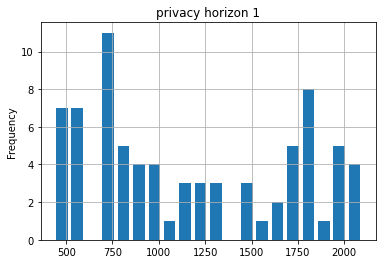

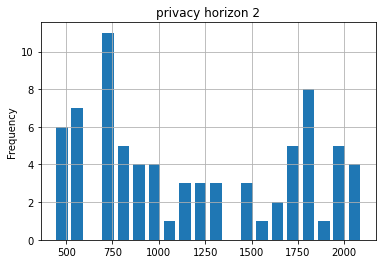

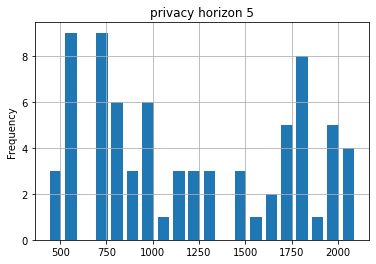

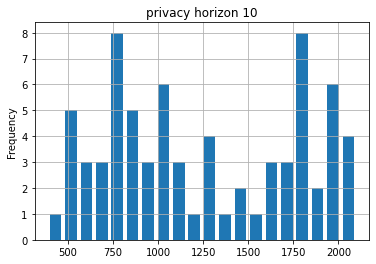

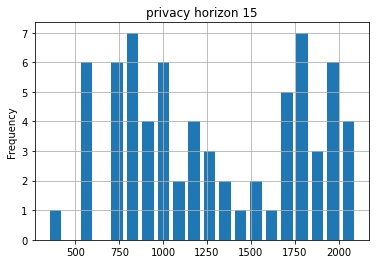

In [26]:
#Privacy distribution
for h in horizons:
    plt.figure()
    plt.title('privacy horizon '+str(h))
    Data_MPC[h].priv.loc[Data_MPC[h].util>0].plot.hist(grid=True, bins=20, rwidth=0.75)
    plt.show()

In [27]:
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output, save
from bokeh.layouts import gridplot, row, column
from bokeh.models import Range1d
from numpy import random
output_notebook()

## Trace plot
Colors = []
fig = figure(plot_width=900, plot_height=450)
fig.line(xsp, ysp, line_color='navy', legend_label="p")
fig.circle(np.multiply(xs,bs), np.multiply(ys,bs), color='navy', legend_label="p")
fig.line(barxk, baryk, line_color='navy', legend_label="centr", alpha=0.2)
fig.circle(barxk, baryk, color='navy', legend_label="centr", fill_alpha=0.2, alpha=0.2)
fig.circle(np.multiply(x_obf,bs), np.multiply(y_obf,bs), color='orange', legend_label="p obf")
#fig.line(barxk_obf, baryk_obf, line_color='orange', legend_label="centr obf", alpha=0.2)
#fig.circle(barxk_obf, baryk_obf, color='orange', legend_label="centr obf", fill_alpha=0.2, alpha=0.2)
for h in horizons:
    x_mpc = Data_MPC[h].x
    y_mpc = Data_MPC[h].y
    barxk_mpc = Data_MPC[h].barx
    baryk_mpc = Data_MPC[h].bary
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    Colors += [color]
    fig.circle(np.multiply(x_mpc,bs[0:len(y_mpc)]), 
           np.multiply(y_mpc,bs[0:len(y_mpc)]), color=color, legend_label="p mpc "+str(h))
    #fig.line(barxk_mpc, baryk_mpc, line_color=color, legend_label="centr mpc "+str(h), alpha=0.2)
    #fig.circle(barxk_mpc, baryk_mpc, color=color, legend_label="centr mpc "+str(h), fill_alpha=0.2, alpha=0.2)
fig.xaxis.axis_label = "x"
fig.yaxis.axis_label = "y"
show(fig)


##Privacy plot
fig = figure(plot_width=900, plot_height=450)
fig.line(Time[bs>0], np.array(privk)[bs>0], line_color='navy', legend_label="p")
fig.circle(Time[bs>0], np.array(privk)[bs>0], color='navy', legend_label="p ")
fig.line(Time[bs>0], np.array(privk_obf)[bs>0], line_color='orange', legend_label="p GeoI")
fig.circle(Time[bs>0], np.array(privk_obf)[bs>0], color='orange', legend_label="p GeoI")

i = 0
for h in horizons:
    priv_mpc = Data_MPC[h].priv
    fig.line(Time[0:len(priv_mpc)], priv_mpc, line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], priv_mpc[0:len(priv_mpc)], color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)


#Log privacy plot
fig = figure(plot_width=900, plot_height=450)
fig.line(Time[(bs>0) & (np.array(privk)>0)], np.log10(np.array(privk)[(bs>0) & (np.array(privk)>0)]), line_color='navy', legend_label="p")
fig.circle(Time[(bs>0) & (np.array(privk)>0)], np.log10(np.array(privk)[(bs>0) & (np.array(privk)>0)]), color='navy', legend_label="p GeoI")
fig.line(Time[(bs>0) & (np.array(privk)>0)], np.log10(np.array(privk_obf)[(bs>0) & (np.array(privk)>0)]), line_color='orange', legend_label="p GeoI")
fig.circle(Time[(bs>0) & (np.array(privk)>0)], np.log10(np.array(privk_obf)[(bs>0) & (np.array(privk)>0)]), color='orange', legend_label="p GeoI")

i = 0
for h in horizons:
    priv_mpc = Data_MPC[h].priv
    fig.line(Time[0:len(priv_mpc)], np.log10(priv_mpc), line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], np.log10(priv_mpc[0:len(priv_mpc)]), color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)


## Log utility plot
fig = figure(plot_width=900, plot_height=250)
# fig.line(Time, util, line_color='orange', legend_label="util obf")
fig.circle(Time[bs>0], np.array(util)[bs>0], color='orange', legend_label="util Geo-I")
i = 0
for h in horizons:
    util_mpc = Data_MPC[h].util
#     fig.line(Time[0:len(util_mpc)], util_mpc, line_color=Colors[i], legend_label="util mpc "+str(h))
    fig.circle(Time[0:len(util_mpc)][bs[0:len(util_mpc)]>0], util_mpc[bs[0:len(util_mpc)]>0], color=Colors[i], legend_label="util mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "utility loss"
show(fig)



Loading BokehJS ...

C:\Users\emolina\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
fig = figure(plot_width=900, plot_height=450)
fig.line(np.array([0]+horizons), [(p_obf-p_raw)/p_raw]+Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.circle(np.array([0]+horizons), [(p_obf-p_raw)/p_raw]+Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.xaxis.axis_label = "horizon"
fig.yaxis.axis_label = "privacy improvement"
fig.x_range = Range1d(0, max(horizons))
fig.y_range = Range1d(0, max(Pper_mpc)*1.25)
show(fig)


In [29]:
fig = figure(plot_width=900, plot_height=450)
fig.line(np.array(horizons), Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.circle(np.array(horizons), Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.line(np.array(horizons), [(p_obf-p_raw)/p_raw]*len(horizons), line_color='red', legend_label="privacy gain gaussian %")
fig.xaxis.axis_label = "horizon"
fig.yaxis.axis_label = "privacy improvement"
fig.x_range = Range1d(1, max(horizons))
fig.y_range = Range1d(0, max(Pper_mpc)*1.25)
show(fig)

# Visualisation on a map

Traces will be plotted using [geojson.io](https://geojson.io/) tool, "Open" option in the menu. Data will be exported in csv with the following columns: marker-color,lat,lon Color should be specified using the HEX color code
### Raw trace

In [30]:
l_raw=pd.DataFrame() 
l_raw['lat'], l_raw['lon'] = pymap3d.enu2geodetic(Data_real['x'], Data_real['y'], Data_real['u_enu'], lat0, lon0, h0, ell=ell_grs80)[0:2]
l_raw['marker-color'] = '#000080'
os.makedirs(sol_file+'/visualisation-map', exist_ok=True)
l_raw.to_csv(sol_file+'/visualisation-map/'+dataset+'_'+user+'_raw.csv')

### GeoI trace

### GeoI trace

In [31]:
Data_obf2=Data_obf[Data_obf.util!=0]

In [32]:
#Modify to plot transmitted points
l_geoi=pd.DataFrame() 

l_geoi['lat'], l_geoi['lon'] = pymap3d.enu2geodetic(Data_obf[Data_obf.util!=0]['x'], Data_obf[Data_obf.util!=0]['y'], Data_obf[Data_obf.util!=0]['u_enu'], lat0, lon0, h0, ell=ell_grs80)[0:2]
l_geoi['marker-color'] = '#FF8000'
l_geoi.to_csv(sol_file+'/visualisation-map/'+dataset+'_'+user+'_geoi.csv')

### MPC trace H

In [33]:
H = 5
l_mpc=pd.DataFrame() 
l_mpc['lat'], l_mpc['lon'] = pymap3d.enu2geodetic(Data_MPC[H]['x'], Data_MPC[H]['y'], Data_MPC[H]['u_enu'], lat0, lon0, h0, ell=ell_grs80)[0:2]
l_mpc['marker-color'] = '#7CFC00'
l_mpc.to_csv(sol_file+'/visualisation-map/'+dataset+'_'+user+'_mpc_'+str(H)+'.csv')